In [33]:
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from scipy.stats import hypergeom
from goatools import obo_parser
from functools import partial

import os
import time
import graco
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

In [35]:
name2string = {'GCV_tvd':'TVD', 'GCV_hellinger':'GCV_{hell}', 'GDV_similarity':'Tijana',
               
               'GDV_euclidean'  :'GDV_{eucl}'  , 'GDV_zscore_euclidean'  :'GDV_{z-eucl}'  , 
               'GDV_cityblock'  :'GDV_{city}'  , 'GDV_zscore_cityblock'  :'GDV_{z-city}'  , 
               'GDV_seuclidean' :'GDV_{seucl}' , 'GDV_zscore_seuclidean' :'GDV_{z-seucl}' ,
               'GDV_cosine'     :'GDV_{cos}'   , 'GDV_zscore_cosine'     :'GDV_{z-cos}'   ,
               'GDV_correlation':'GDV_{cor}'   , 'GDV_zscore_correlation':'GDV_{z-cor}'   ,
               'GDV_sqeuclidean':'GDV_{eucl^2}', 'GDV_zscore_sqeuclidean':'GDV_{z-eucl^2}',
               'GDV_chebyshev'  :'GDV_{cheby}' , 'GDV_zscore_chebyshev'  :'GDV_{z-cheby}' ,
               'GDV_canberra'   :'GDV_{can}'   , 'GDV_zscore_canberra'   :'GDV_{z-can}'   ,
               'GDV_braycurtis' :'GDV_{bray}'  , 'GDV_zscore_braycurtis' :'GDV_{z-bray}'  ,
               'GDV_mahalanobis':'GDV_{mahala}', 'GDV_zscore_mahalanobis':'GDV_{z-mahala}',
               
               'GCV_euclidean'  :'GCV_{eucl}'  , 'GCV_zscore_euclidean'  :'GCV_{z-eucl}'  , 
               'GCV_cityblock'  :'GCV_{city}'  , 'GCV_zscore_cityblock'  :'GCV_{z-city}'  , 
               'GCV_seuclidean' :'GCV_{seucl}' , 'GCV_zscore_seuclidean' :'GCV_{z-seucl}' ,
               'GCV_cosine'     :'GCV_{cos}'   , 'GCV_zscore_cosine'     :'GCV_{z-cos}'   ,
               'GCV_correlation':'GCV_{cor}'   , 'GCV_zscore_correlation':'GCV_{z-cor}'   ,
               'GCV_sqeuclidean':'GCV_{eucl^2}', 'GCV_zscore_sqeuclidean':'GCV_{z-eucl^2}',
               'GCV_chebyshev'  :'GCV_{cheby}' , 'GCV_zscore_chebyshev'  :'GCV_{z-cheby}' ,
               'GCV_canberra'   :'GCV_{can}'   , 'GCV_zscore_canberra'   :'GCV_{z-can}'   ,
               'GCV_braycurtis' :'GCV_{bray}'  , 'GCV_zscore_braycurtis' :'GCV_{z-bray}'  ,
               'GCV_mahalanobis':'GCV_{mahala}', 'GCV_zscore_mahalanobis':'GCV_{z-mahala}',
              
              'gGCV_euclidean'  :'new GCV_{eucl}'  , 'GCV_zscore_euclidean'  :'GCV_{z-eucl}'  ,
              'gGCV_cityblock'  :'new GCV_{city}'  , 'GCV_zscore_cityblock'  :'GCV_{z-city}'  ,
              'gGCV_seuclidean' :'new GCV_{seucl}' , 'GCV_zscore_seuclidean' :'GCV_{z-seucl}' ,
              'gGCV_cosine'     :'new GCV_{cos}'   , 'GCV_zscore_cosine'     :'GCV_{z-cos}'   ,
              'gGCV_correlation':'new GCV_{cor}'   , 'GCV_zscore_correlation':'GCV_{z-cor}'   ,
              'gGCV_sqeuclidean':'new GCV_{eucl^2}', 'GCV_zscore_sqeuclidean':'GCV_{z-eucl^2}',
              'gGCV_chebyshev'  :'new GCV_{cheby}' , 'GCV_zscore_chebyshev'  :'GCV_{z-cheby}' ,
              'gGCV_canberra'   :'new GCV_{can}'   , 'GCV_zscore_canberra'   :'GCV_{z-can}'   ,
              'gGCV_braycurtis' :'new GCV_{bray}'  , 'GCV_zscore_braycurtis' :'GCV_{z-bray}'  ,
              'gGCV_mahalanobis':'new GCV_{mahala}', 'GCV_zscore_mahalanobis':'GCV_{z-mahala}',
              'gGCV_normalizedl1':'GCV_{L_1}',
              'gGCV_normalizedl2': 'GCV_{L_2}',
              'gGCV_normalizedlinf':'GCV_{L_{\infty}}'}

# Load

In [36]:
namespace = 'BP'
correction = 'BY'

In [37]:
cluster_coverages = defaultdict(pd.DataFrame)
GO_coverages      = defaultdict(pd.DataFrame)
gene_coverages    = defaultdict(pd.DataFrame)

In [38]:
ENRICHMENT_PATH = f"{DATA_DIRECTORY}/enrichments/{namespace}/{correction}"

for method in [
                'GDV_similarity',
                'gGCV_normalizedl1',
                'gGCV_normalizedl2',
                'gGCV_normalizedlinf',
                'GDV_mahalanobis'
                #'GCV_tvd',
               ]:
    cluster_coverages[method] = pd.read_csv(f"{ENRICHMENT_PATH}/{method}/cluster_coverage.txt", 
                                            index_col=0)
    GO_coverages[method] = pd.read_csv(f"{ENRICHMENT_PATH}/{method}/GO_coverage.txt", 
                                       index_col=0)
    gene_coverages[method] = pd.read_csv(f"{ENRICHMENT_PATH}/{method}/gene_coverage.txt", 
                                         index_col=0)

# Plots

In [39]:
plot_methods = [
                'GDV_similarity', 
                'gGCV_normalizedl1', 
                'gGCV_normalizedl2',
                'gGCV_normalizedlinf',
                #'GCV_tvd',
                'GDV_mahalanobis', 
                
                #'gGCV_normalizedlinf'
               ]

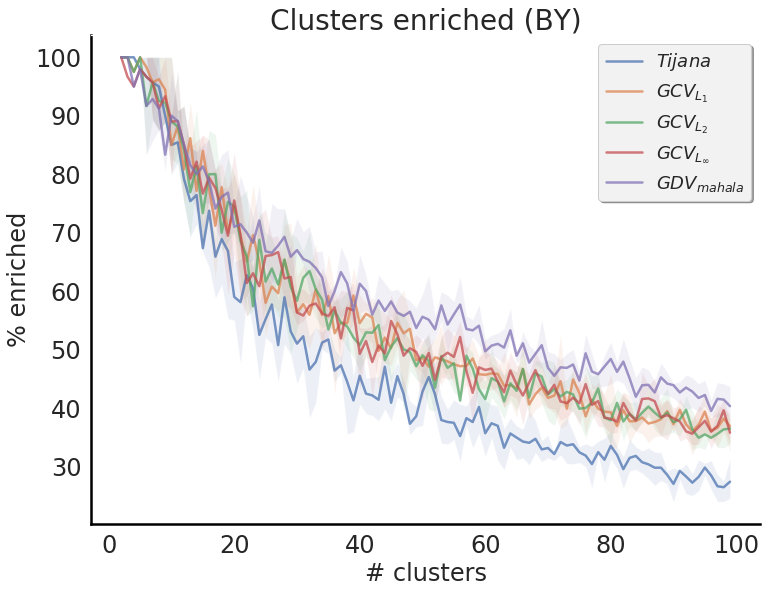

In [40]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    ax.plot(cluster_coverages[method].index, 100*cluster_coverages[method].T.mean(), 
            label=f'${name2string[method]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(cluster_coverages[method].index, 
                     100*cluster_coverages[method].T.quantile(0.25), 
                     100*cluster_coverages[method].T.quantile(0.75), 
                     alpha=0.1,);
    ax.set_title(f'Clusters enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

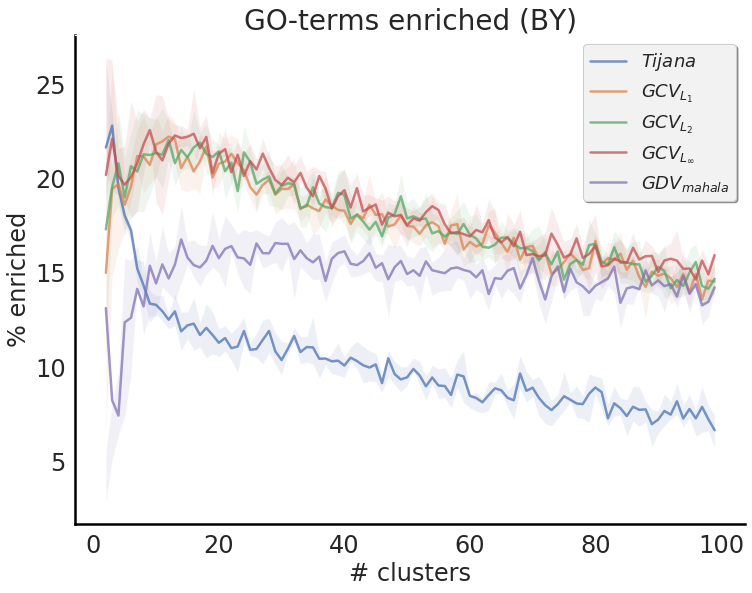

In [41]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    ax.plot(GO_coverages[method].index, 100*GO_coverages[method].T.mean(), 
            label=f'${name2string[method]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(GO_coverages[method].index, 
                     100*GO_coverages[method].T.quantile(0.25), 
                     100*GO_coverages[method].T.quantile(0.75), 
                     alpha=0.1,);
    ax.set_title(f'GO-terms enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_GO-term.png")

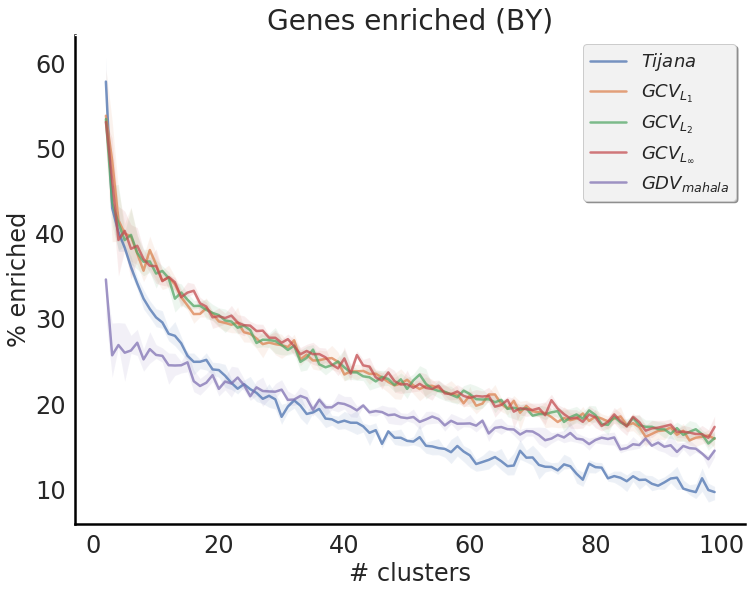

In [42]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    ax.plot(gene_coverages[method].index, 100*gene_coverages[method].T.mean(), 
            label=f'${name2string[method]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(gene_coverages[method].index,
                     100*gene_coverages[method].T.quantile(0.25), 
                     100*gene_coverages[method].T.quantile(0.75), 
                     alpha=0.1,);
    ax.set_title(f'Genes enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_gene.png")